# Documentation

**Author:** Anirudh  
**Date:** 09/04/2025  

### Modification Details:
- **Model Change:** Replacing Linear Mixed Models (LMM) with Ordinary Least Squares (OLS).
- **Predictors Update:** Including each sleep variable, ICV, Gender, and other relevant variables as predictors.
- **Outcome Update:** Separating outcomes into two categories:
    - MRI variables.
    - Cognitive test variables.
- **Variables change:** Replacing Adjusted Age to AGE
- **Additional changes:** Changing the groupby function for the OLS results (instead of grouping by Outcome and feature, grouped by model)
    - Added model name = outcome + feature
    - Changed the formula to have sleep variable + features instead of features + sleep variable
    - ICV is irrelevant to cognitive outcomes, so removed it for the cognitive outcomes
    - Instead of normalizing for ICV, using ICV as covariate instead
    - Check for the insomnia categorization

In [109]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [110]:
adnimerge = pd.read_csv("Imp_Files/ADNIMERGE_07Jan2024.csv")
ICV_info = adnimerge[['VISCODE','ICV','RID']]

C:\Users\anisr\AppData\Local\Temp\ipykernel_3504\879423613.py:1: DtypeWarning: Columns (19,20,21,50,51,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  adnimerge = pd.read_csv("Imp_Files/ADNIMERGE_07Jan2024.csv")


In [111]:
sleep_data = pd.read_csv('Longitudinal sleep.csv')
volumes_data = pd.read_csv('Volumes_merge.csv')

In [112]:
volumes_data = volumes_data.drop(['Month', 'Years_bl'],axis=1)
sleep_data.rename(columns={"VISCODE2": "VISCODE"}, inplace=True)

In [113]:
cognitive_outcomes = ['ADNI_MEM', 'ADNI_EF', 'ADNI_LAN', 'ADNI_VS', 'ADNI_EF2']
sleep_vars = ['NPIK', 'NPIKSEV', 'Sleep_Apnea', 'Restless_Legs',
              'Insomnia', 'Sleep_Disturbance_Other']
mri_vars = ['Brainstem', 'CorpusCallosumAnterior', 'CorpusCallosumCentral', 'CorpusCallosumMidAnterior', 'CorpusCallosumMidPosterior', 'CorpusCallosumPosterior', 'Csf', 'RightParacentral', 'RightParahippocampal', 'RightParsOpercularis', 'RightParsOrbitalis', 'RightParsTriangularis', 'RightPericalcarine', 'RightPostcentral', 'RightPosteriorCingulate', 'RightPrecentral', 'RightPrecuneus', 'RightRostralAnteriorCingulate', 'RightRostralMiddleFrontal', 'RightSuperiorFrontal', 'RightSuperiorParietal', 'RightSuperiorTemporal', 'RightSupramarginal', 'RightTemporalPole', 'RightTransverseTemporal', 'RightUnknown', 'LeftInsula', 'RightInsula', 'LeftBankssts', 'LeftCaudalAnteriorCingulate', 'LeftCaudalMiddleFrontal', 'LeftCuneus', 'LeftEntorhinal', 'LeftFrontalPole', 'LeftFusiform', 'LeftInferiorParietal', 'LeftInferiorTemporal', 'LeftIsthmusCingulate', 'LeftLateralOccipital', 'LeftLateralOrbitofrontal', 'LeftLingual', 'LeftMedialOrbitofrontal', 'LeftMiddleTemporal', 'LeftParacentral', 'LeftParahippocampal', 'LeftParsOpercularis', 'LeftParsOrbitalis', 'LeftParsTriangularis', 'LeftPericalcarine', 'LeftPostcentral', 'LeftPosteriorCingulate', 'LeftPrecentral', 'LeftPrecuneus', 'LeftRostralAnteriorCingulate', 'LeftRostralMiddleFrontal',
            'LeftSuperiorFrontal', 'LeftSuperiorParietal', 'LeftSuperiorTemporal', 'LeftSupramarginal', 'LeftTemporalPole', 'LeftTransverseTemporal', 'LeftUnknown', 'RightBankssts', 'RightCaudalAnteriorCingulate', 'RightCaudalMiddleFrontal', 'RightCuneus', 'RightEntorhinal', 'RightFrontalPole', 'RightFusiform', 'RightInferiorParietal', 'RightInferiorTemporal', 'RightIsthmusCingulate', 'RightLateralOccipital', 'RightLateralOrbitofrontal', 'RightLingual', 'RightMedialOrbitofrontal', 'RightMiddleTemporal', 'FourthVentricle', 'Icv', 'LeftAccumbensArea', 'LeftAmygdala', 'LeftCaudate', 'LeftCerebellumCortex', 'LeftCerebellumWM', 'LeftCerebralCortex', 'LeftCerebralWM', 'LeftChoroidPlexus', 'LeftHemisphere', 'LeftHippocampus', 'LeftInferiorLateralVentricle', 'LeftLateralVentricle', 'LeftPallidum', 'LeftPutamen', 'LeftThalamus', 'LeftVentralDC', 'LeftVessel', 'NonWMHypoIntensities', 'OpticChiasm', 'RightAccumbensArea', 'RightAmygdala', 'RightCaudate', 'RightCerebellumCortex', 'RightCerebellumWM', 'RightCerebralCortex', 'RightCerebralWM', 'RightChoroidPlexus', 'RightHemisphere', 'RightHippocampus', 'RightInferiorLateralVentricle', 'RightLateralVentricle', 'RightPallidum', 'RightPutamen', 'RightThalamus', 'RightVentralDC', 'ThirdVentricle', 'WMHypoIntensities']

In [114]:
volumes_data = pd.merge(volumes_data, ICV_info, on = ['RID','VISCODE'])

In [115]:
continuous_vars = cognitive_outcomes + mri_vars
constant_vars = ['ICV', 'PTGENDER', 'Adjusted_Age','PTEDUCAT']

In [116]:
volumes_data.columns[volumes_data.isnull().any()]


Index(['DX', 'ADNI_MEM', 'ADNI_EF', 'ADNI_VS', 'ADNI_LAN', 'ADNI_EF2'], dtype='object')

In [117]:
volumes_data.at[1819, 'DX'] = 'Dementia'

In [118]:
volumes_data.fillna(method='ffill', inplace=True)

In [119]:
from sklearn.preprocessing import LabelEncoder

categorical_columns_sleep = ['Sleep_Quality','VISCODE']

label_encoders = {}

for column in volumes_data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    volumes_data[column] = le.fit_transform(volumes_data[column].astype(str))
    label_encoders[column] = le

for column in categorical_columns_sleep:
    le = LabelEncoder()
    sleep_data[column] = le.fit_transform(sleep_data[column].astype(str))
    label_encoders[column] = le

In [120]:
label_encoders

{'VISCODE': LabelEncoder(),
 'DX_bl': LabelEncoder(),
 'PTGENDER': LabelEncoder(),
 'PTETHCAT': LabelEncoder(),
 'PTRACCAT': LabelEncoder(),
 'PTMARRY': LabelEncoder(),
 'DX': LabelEncoder(),
 'Sleep_Quality': LabelEncoder()}

In [121]:
sleep_data['NPIKSEV'].value_counts()

-4.0    1756
 1.0     217
 2.0      94
 3.0      21
Name: NPIKSEV, dtype: int64

In [122]:
sleep_data['NPIKSEV'].replace(-4.0, 0,inplace=True)

In [123]:
corr_results_volumes = []

for cont_var in continuous_vars:
    for const_var in constant_vars:
        valid_data = volumes_data[[cont_var, const_var]].dropna()
        if not valid_data.empty:  
            corr, p_val = pearsonr(valid_data[cont_var], valid_data[const_var])
            corr_results_volumes.append({
                'Dataset': 'Volumes',
                'Continuous_Variable': cont_var,
                'Constant_Variable': const_var,
                'Correlation': corr,
                'P_Value': p_val
            })

corr_df_volumes = pd.DataFrame(corr_results_volumes)

In [124]:
corr_results_sleep = []
for sleep_var in sleep_vars:
    for const_var in constant_vars:
        corr, p_val = pearsonr(
            sleep_data[sleep_var], volumes_data[const_var])
        corr_results_sleep.append({
            'Dataset': 'Sleep',
            'Continuous_Variable': sleep_var,
            'Constant_Variable': const_var,
            'Correlation': corr,
            'P_Value': p_val
        })

corr_df_sleep = pd.DataFrame(corr_results_sleep)

In [125]:
corr_df_combined = pd.concat([corr_df_volumes, corr_df_sleep], ignore_index=True)

In [126]:
from statsmodels.stats.multitest import multipletests

corr_df_combined['FDR_P_Value'] = multipletests(
    corr_df_combined['P_Value'], method='fdr_bh')[1]

In [127]:
corr_df_combined['FWER_P_Value'] = multipletests(
    corr_df_combined['P_Value'], method='bonferroni')[1]

In [128]:
corr_df_combined.sort_values(by='FDR_P_Value', ascending=True)

,Dataset,Continuous_Variable,Constant_Variable,Correlation,P_Value,FDR_P_Value,FWER_P_Value
436,Volumes,RightCerebralWM,ICV,0.727570,0.000000,0.000000,0.0
368,Volumes,LeftHemisphere,ICV,0.851524,0.000000,0.000000,0.0
332,Volumes,Icv,ICV,0.999975,0.000000,0.000000,0.0
360,Volumes,LeftCerebralWM,ICV,0.719855,0.000000,0.000000,0.0
444,Volumes,RightHemisphere,ICV,0.857177,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...
195,Volumes,LeftParacentral,PTEDUCAT,0.003329,0.879173,0.886151,1.0
490,Sleep,NPIKSEV,Adjusted_Age,0.002206,0.919758,0.925222,1.0
155,Volumes,LeftFrontalPole,PTEDUCAT,-0.000856,0.968834,0.972664,1.0
485,Sleep,NPIK,PTGENDER,-0.000684,0.975070,0.976993,1.0


In [129]:
corr_df_combined[corr_df_combined['FDR_P_Value'] < 0.05]

,Dataset,Continuous_Variable,Constant_Variable,Correlation,P_Value,FDR_P_Value,FWER_P_Value
0,Volumes,ADNI_MEM,ICV,-0.096246,1.055212e-05,1.493169e-05,5.360475e-03
1,Volumes,ADNI_MEM,PTGENDER,-0.096763,9.453817e-06,1.341491e-05,4.802539e-03
3,Volumes,ADNI_MEM,PTEDUCAT,0.160559,1.580090e-13,3.006313e-13,8.026855e-11
4,Volumes,ADNI_EF,ICV,-0.060831,5.426797e-03,6.595246e-03,1.000000e+00
5,Volumes,ADNI_EF,PTGENDER,-0.049583,2.346875e-02,2.697313e-02,1.000000e+00
...,...,...,...,...,...,...,...
500,Sleep,Insomnia,ICV,-0.107196,9.130639e-07,1.352293e-06,4.638365e-04
501,Sleep,Insomnia,PTGENDER,-0.095752,1.171677e-05,1.653366e-05,5.952119e-03
502,Sleep,Insomnia,Adjusted_Age,0.052482,1.646915e-02,1.923294e-02,1.000000e+00
503,Sleep,Insomnia,PTEDUCAT,-0.072436,9.253301e-04,1.178114e-03,4.700677e-01


In [73]:
corr_df_combined[corr_df_combined['FWER_P_Value'] < 0.05]

,Dataset,Continuous_Variable,Constant_Variable,Correlation,P_Value,FDR_P_Value,FWER_P_Value
0,Volumes,ADNI_MEM,ICV,-0.096246,1.055212e-05,1.504926e-05,5.402684e-03
1,Volumes,ADNI_MEM,PTGENDER,-0.096763,9.453817e-06,1.352054e-05,4.840354e-03
3,Volumes,ADNI_MEM,PTEDUCAT,0.160559,1.580090e-13,3.029985e-13,8.090059e-11
6,Volumes,ADNI_EF,Adjusted_Age,-0.087635,6.078065e-05,8.298585e-05,3.111969e-02
7,Volumes,ADNI_EF,PTEDUCAT,0.223832,4.037161e-25,9.937626e-25,2.067026e-22
...,...,...,...,...,...,...,...
480,Volumes,WMHypoIntensities,ICV,0.308521,2.772331e-47,1.006690e-46,1.419434e-44
481,Volumes,WMHypoIntensities,PTGENDER,0.117552,7.165900e-08,1.157395e-07,3.668941e-05
482,Volumes,WMHypoIntensities,Adjusted_Age,0.289872,1.052231e-41,3.567828e-41,5.387420e-39
500,Sleep,Insomnia,ICV,-0.107196,9.130639e-07,1.362941e-06,4.674887e-04


In [130]:
fdr_significant_df = corr_df_combined[corr_df_combined['FDR_P_Value'] < 0.05]
fwer_significant_df = corr_df_combined[corr_df_combined['FWER_P_Value'] < 0.05]
fdr_significant_df.to_csv('supplementary_tables/FDR_Significant_Features.csv', index=False)
fwer_significant_df.to_csv('supplementary_tables/FWER_Significant_Features.csv', index=False)

In [131]:
volumes_data.to_csv('Updated_merge.csv', index=False)
sleep_data.to_csv('Updated_sleep.csv', index=False)

In [132]:
volumes_data['ICV'].mean()

1568318.1417624522

In [133]:
(volumes_data['ICV'] > volumes_data['ICV'].mean()).sum()

1004

In [134]:
volumes_data_norm = volumes_data.copy()

high_icv_threshold = volumes_data_norm['ICV'].mean()
volumes_data_norm['High_ICV'] = volumes_data_norm['ICV'] > high_icv_threshold

mri_vars_adjusted = [var for var in mri_vars if var != 'ICV']

for var in mri_vars_adjusted:
    volumes_data_norm[f'{var}_norm'] = volumes_data_norm[var] / \
        volumes_data_norm['ICV']
volumes_data_norm.drop(columns=mri_vars_adjusted, inplace=True)

C:\Users\anisr\AppData\Local\Temp\ipykernel_3504\2757077334.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  volumes_data_norm[f'{var}_norm'] = volumes_data_norm[var] / \
C:\Users\anisr\AppData\Local\Temp\ipykernel_3504\2757077334.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  volumes_data_norm[f'{var}_norm'] = volumes_data_norm[var] / \
C:\Users\anisr\AppData\Local\Temp\ipykernel_3504\2757077334.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

In [135]:
volumes_data_norm.to_csv("supplementary_tables/Volumes_norm_ICV.csv", index=False)

In [136]:
volumes_data

,VISCODE,RID,Brainstem,CorpusCallosumAnterior,CorpusCallosumCentral,CorpusCallosumMidAnterior,CorpusCallosumMidPosterior,CorpusCallosumPosterior,Csf,RightParacentral,...,MH2NEURL,MH4CARD,MH5RESP,MH19OTHR,ADNI_MEM,ADNI_EF,ADNI_VS,ADNI_LAN,ADNI_EF2,ICV
0,0,3,24577.0,790.0,375.0,341.0,307.0,735.0,1905.0,3539.0,...,0,1,0,0,-1.021,-1.144,-0.880,-1.368,-1.062,1920690.0
1,1,3,23784.0,774.0,378.0,358.0,314.0,701.0,2022.0,3474.0,...,0,1,0,0,-1.187,-0.674,-1.221,-1.638,-0.670,1906430.0
2,2,3,23759.0,763.0,369.0,323.0,307.0,721.0,2176.0,3234.0,...,0,1,0,0,-0.914,-0.969,-0.548,-1.837,-1.034,1903820.0
3,3,3,23324.0,717.0,351.0,317.0,319.0,707.0,2023.0,3499.0,...,0,1,0,0,-1.369,-1.511,0.739,-1.700,-1.605,1903420.0
4,0,5,22015.0,960.0,451.0,470.0,368.0,1136.0,1423.0,2862.0,...,0,0,0,0,0.743,0.165,0.739,0.259,-0.152,1640770.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2083,3,1425,18719.0,477.0,291.0,267.0,282.0,740.0,1191.0,2951.0,...,0,1,0,0,-1.661,-1.078,0.739,-2.517,-0.826,1334060.0
2084,0,1427,18408.0,920.0,365.0,418.0,395.0,938.0,1534.0,3121.0,...,0,1,1,0,-0.366,-1.746,-1.530,-0.492,-2.042,1515920.0
2085,1,1427,18996.0,1001.0,392.0,438.0,348.0,902.0,1446.0,3287.0,...,0,1,1,0,-1.445,-1.642,-1.813,-1.640,-1.788,1549380.0
2086,2,1427,18506.0,917.0,363.0,388.0,391.0,937.0,1470.0,3352.0,...,0,1,1,0,-1.764,-1.625,-0.656,-0.946,-2.047,1557540.0


In [137]:
merge_norm = pd.merge(volumes_data, sleep_data, on=['RID', 'VISCODE'])

In [138]:
constant_vars = ['ICV', 'PTGENDER', 'Adjusted_Age', 'PTEDUCAT']
continuous_vars = cognitive_outcomes + sleep_vars + \
    mri_vars

correlation_results = []

for const_var in constant_vars:
    for cont_var in continuous_vars:
        valid_data = merge_norm[[const_var, cont_var]].dropna()

        if len(valid_data) > 0:
            corr_value, p_value = pearsonr(
                valid_data[const_var], valid_data[cont_var])

            correlation_results.append({
                'Constant_Var': const_var,
                'Continuous_Var': cont_var,
                'Correlation': corr_value,
                'P_Value': p_value
            })

correlation_results_df = pd.DataFrame(correlation_results)

In [139]:
correlation_results_df[
    (correlation_results_df['P_Value'] < 0.05) & (
        correlation_results_df['Correlation'].abs() >= 0.3)
]

,Constant_Var,Continuous_Var,Correlation,P_Value
11,ICV,Brainstem,0.618555,1.008331e-220
12,ICV,CorpusCallosumAnterior,0.367702,7.513215e-68
17,ICV,Csf,0.438307,9.247966e-99
18,ICV,RightParacentral,0.448817,4.991151e-104
20,ICV,RightParsOpercularis,0.336134,2.543413e-56
...,...,...,...,...
251,PTGENDER,RightVentralDC,0.387412,9.766994e-76
252,PTGENDER,ThirdVentricle,0.388680,2.909182e-76
268,Adjusted_Age,CorpusCallosumMidAnterior,-0.331861,7.352527e-55
350,Adjusted_Age,LeftCerebralWM,-0.336832,1.461199e-56


In [140]:
correlation_results_df[correlation_results_df['Constant_Var'] == 'ICV'].sort_values(
    by='Correlation', ascending=False).to_csv('supplementary_tables/ICV_Correlation.csv', index=False)

In [141]:
correlation_results_df[correlation_results_df['Constant_Var'].isin(
    ['PTGENDER', 'Adjusted_Age', 'PTEDUCAT'])].to_csv('supplementary_tables/Constant_Correlation.csv', index=False)

In [142]:
mri_outcomes = mri_vars
cognitive_outcomes = cognitive_outcomes
predictorscog = ['PTGENDER', 'AGE', 'PTEDUCAT', 'APOE4']
predictorsmri = ['PTGENDER', 'AGE', 'PTEDUCAT', 'APOE4','ICV']
random_effects_var = 'RID'

In [148]:
sleep_data[sleep_data['Insomnia']==1]['RID'].unique()

array([ 352,  382,  450,  487,  568,  692,  748,  932,  934,  984, 1168,
       1280], dtype=int64)

In [155]:
print(dict(enumerate(label_encoders['DX_bl'].classes_)))
print(dict(enumerate(label_encoders['DX'].classes_)))

{0: 'AD', 1: 'CN', 2: 'LMCI'}
{0: 'CN', 1: 'Dementia', 2: 'MCI'}


In [156]:
merge_norm[merge_norm['RID'].isin(sleep_data[sleep_data['Insomnia'] == 1]['RID'].unique())].drop(['MHDESC'],axis=1)[cognitive_outcomes + ['DX','DX_bl']]

,ADNI_MEM,ADNI_EF,ADNI_LAN,ADNI_VS,ADNI_EF2,DX,DX_bl
575,1.681,1.068,0.236,-0.548,0.550,0,1
576,1.634,1.203,1.270,0.739,0.640,0,1
577,1.485,0.681,0.537,-0.080,0.456,0,1
578,2.224,1.220,1.210,0.739,0.870,0,1
619,1.069,1.535,2.666,0.739,1.138,0,1
620,1.250,1.891,3.151,0.739,1.357,0,1
621,1.961,1.815,3.151,0.739,1.326,0,1
622,2.262,1.815,2.666,0.739,1.326,0,1
732,0.121,0.312,1.000,0.739,0.090,2,2
733,-0.042,0.172,0.430,0.739,0.202,2,2


In [157]:
OLS_results_cognitive = []
OLS_results_mri = []
model_counter = 1

for sleep_var in sleep_vars:
    for outcome in cognitive_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(predictorscog)}"
            model = smf.ols(formula, data=merge_norm).fit()

            for feature in predictorscog + [sleep_var]:
                OLS_results_cognitive.append({
                    'Model_ID': f"model_{model_counter}",
                    'Model_Name': f"{outcome}_{feature}",
                    'Outcome': outcome,
                    'Feature': feature,
                    'Coefficient': model.params[feature],
                    'P-Value': model.pvalues[feature],
                    'R-Squared': model.rsquared,
                    
                })
            model_counter += 1
        except Exception as e:
            print(f"Error fitting model for {outcome} with {sleep_var}: {e}")

for sleep_var in sleep_vars:
    for outcome in mri_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(predictorsmri)}"
            model = smf.ols(formula, data=merge_norm).fit()

            for feature in predictorsmri + [sleep_var]:
                OLS_results_mri.append({
                    'Model_ID': f"model_{model_counter}",
                    'Model_Name': f"{outcome}_{feature}",
                    'Outcome': outcome,
                    'Feature': feature,
                    'Coefficient': model.params[feature],
                    'P-Value': model.pvalues[feature],
                    'R-Squared': model.rsquared,

                })
            model_counter += 1
        except Exception as e:
            print(f"Error fitting model for {outcome} with {sleep_var}: {e}")

In [158]:
OLS_results_cognitive_df = pd.DataFrame(OLS_results_cognitive)
OLS_results_mri_df = pd.DataFrame(OLS_results_mri)

In [160]:
OLS_results_cognitive_df[OLS_results_cognitive_df['Feature'].isin(sleep_vars)]

,Model_ID,Model_Name,Outcome,Feature,Coefficient,P-Value,R-Squared
4,model_1,ADNI_MEM_NPIK,ADNI_MEM,NPIK,-0.343046,6.082000e-09,0.141684
9,model_2,ADNI_EF_NPIK,ADNI_EF,NPIK,-0.320940,2.011326e-08,0.127246
14,model_3,ADNI_LAN_NPIK,ADNI_LAN,NPIK,-0.388612,2.283507e-12,0.119035
19,model_4,ADNI_VS_NPIK,ADNI_VS,NPIK,-0.206459,5.203557e-06,0.064032
24,model_5,ADNI_EF2_NPIK,ADNI_EF2,NPIK,-0.297855,8.544547e-08,0.113630
29,model_6,ADNI_MEM_NPIKSEV,ADNI_MEM,NPIKSEV,-0.326429,2.031684e-14,0.151806
34,model_7,ADNI_EF_NPIKSEV,ADNI_EF,NPIKSEV,-0.288331,3.351085e-12,0.134340
39,model_8,ADNI_LAN_NPIKSEV,ADNI_LAN,NPIKSEV,-0.346217,5.544318e-18,0.129742
44,model_9,ADNI_VS_NPIKSEV,ADNI_VS,NPIKSEV,-0.186507,1.338163e-08,0.069195
49,model_10,ADNI_EF2_NPIKSEV,ADNI_EF2,NPIKSEV,-0.264870,4.855817e-11,0.119806


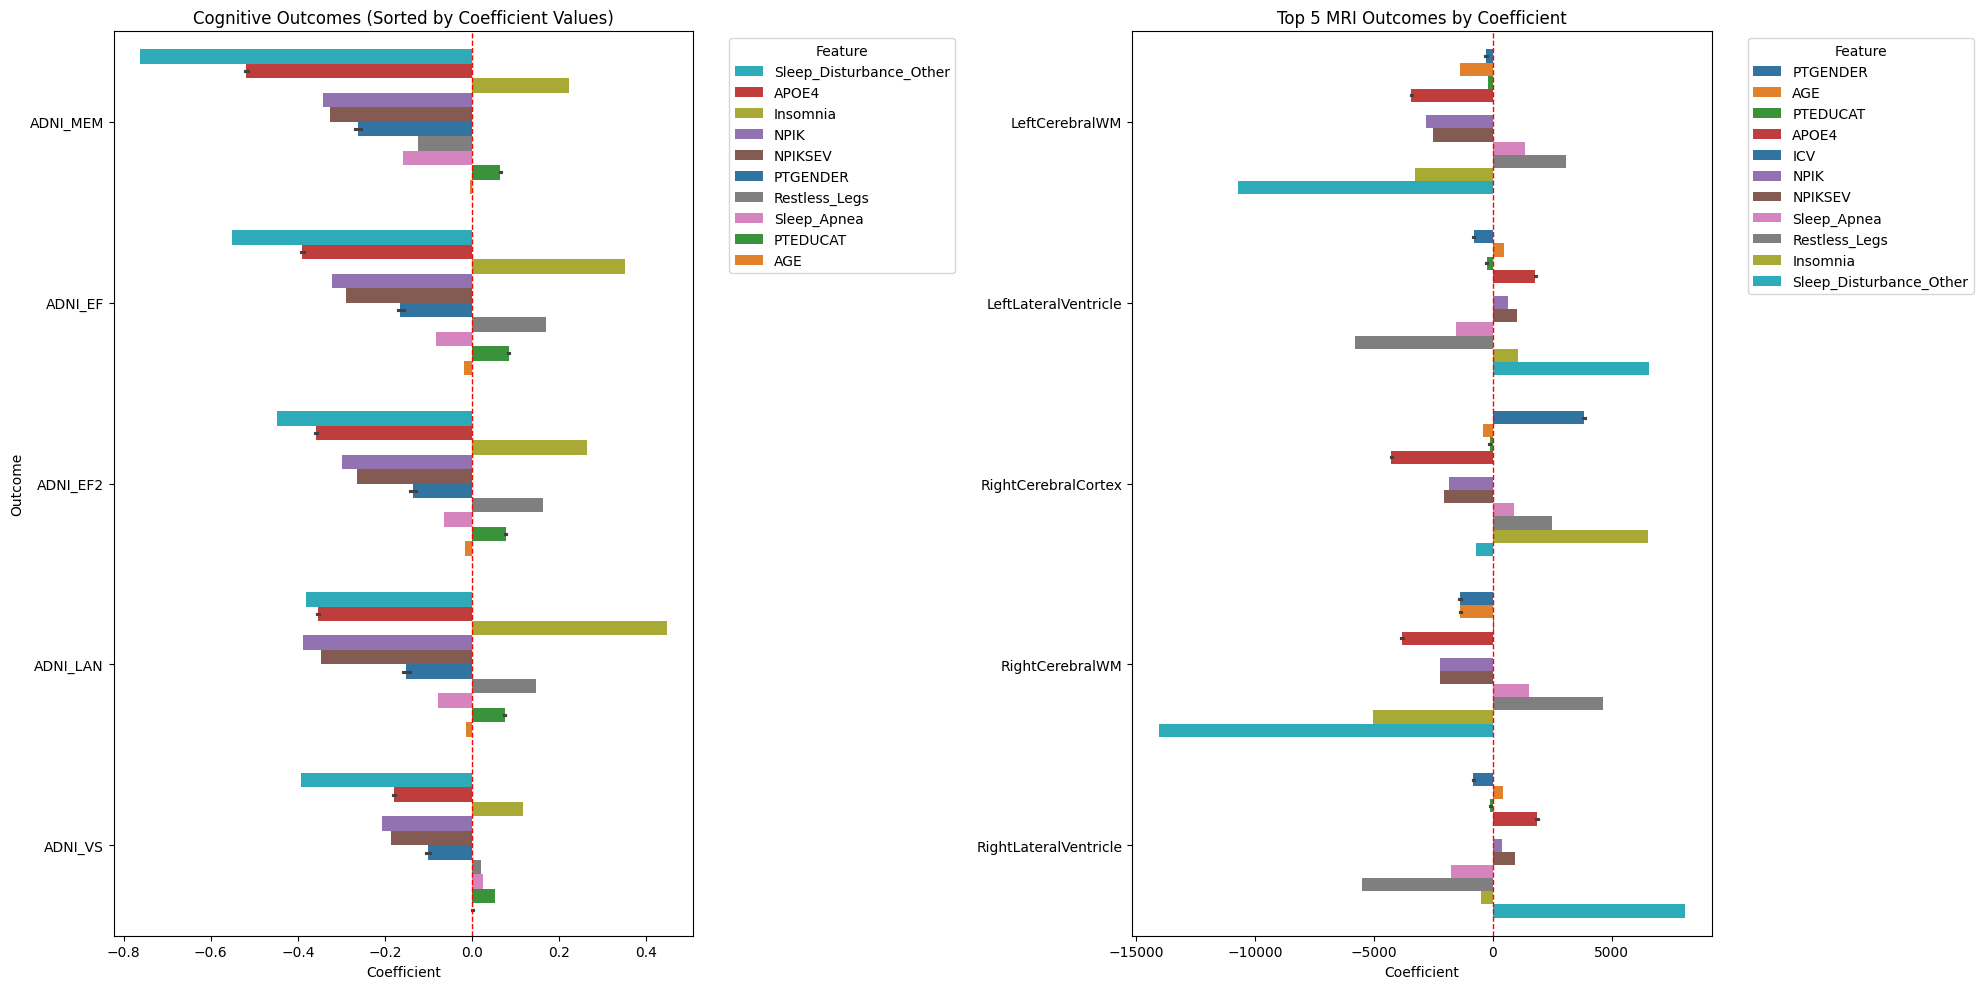

In [161]:
OLS_results_cognitive_df['Type'] = 'Cognitive'
OLS_results_mri_df['Type'] = 'MRI'

combined_OLS_results = pd.concat(
    [OLS_results_cognitive_df, OLS_results_mri_df])

top_5_mri = (
    combined_OLS_results[combined_OLS_results['Type'] == 'MRI']
    .groupby('Outcome')['Coefficient']
    .apply(lambda x: x.abs().max())
    .nlargest(5)  
    .reset_index()
)

filtered_OLS_mri = combined_OLS_results.merge(
    top_5_mri[['Outcome']], on='Outcome')

filtered_OLS_cognitive = (
    combined_OLS_results[combined_OLS_results['Type'] == 'Cognitive']
    .sort_values(by='Coefficient', key=lambda x: x.abs(), ascending=False)
)

features = combined_OLS_results['Feature'].unique()
palette = sns.color_palette("tab10", len(features))
color_dict = dict(zip(features, palette))  

fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=False)

sns.barplot(
    data=filtered_OLS_cognitive,
    x='Coefficient', y='Outcome', hue='Feature', ax=axes[0],
    palette=color_dict 
)
axes[0].set_title('Cognitive Outcomes (Sorted by Coefficient Values)')
axes[0].set_xlabel('Coefficient')
axes[0].set_ylabel('Outcome')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=1)
axes[0].legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')

sns.barplot(
    data=filtered_OLS_mri,
    x='Coefficient', y='Outcome', hue='Feature', ax=axes[1],
    palette=color_dict  
)
axes[1].set_title('Top 5 MRI Outcomes by Coefficient')
axes[1].set_xlabel('Coefficient')
axes[1].set_ylabel('')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=1)
axes[1].legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('supplementary_tables/Top_5_OLS_Coefficients_Subplots.png',
            bbox_inches='tight')
plt.show()

In [176]:
memory_outcomes = cognitive_outcomes
top_5_mri_outcomes = top_5_mri['Outcome'].tolist()

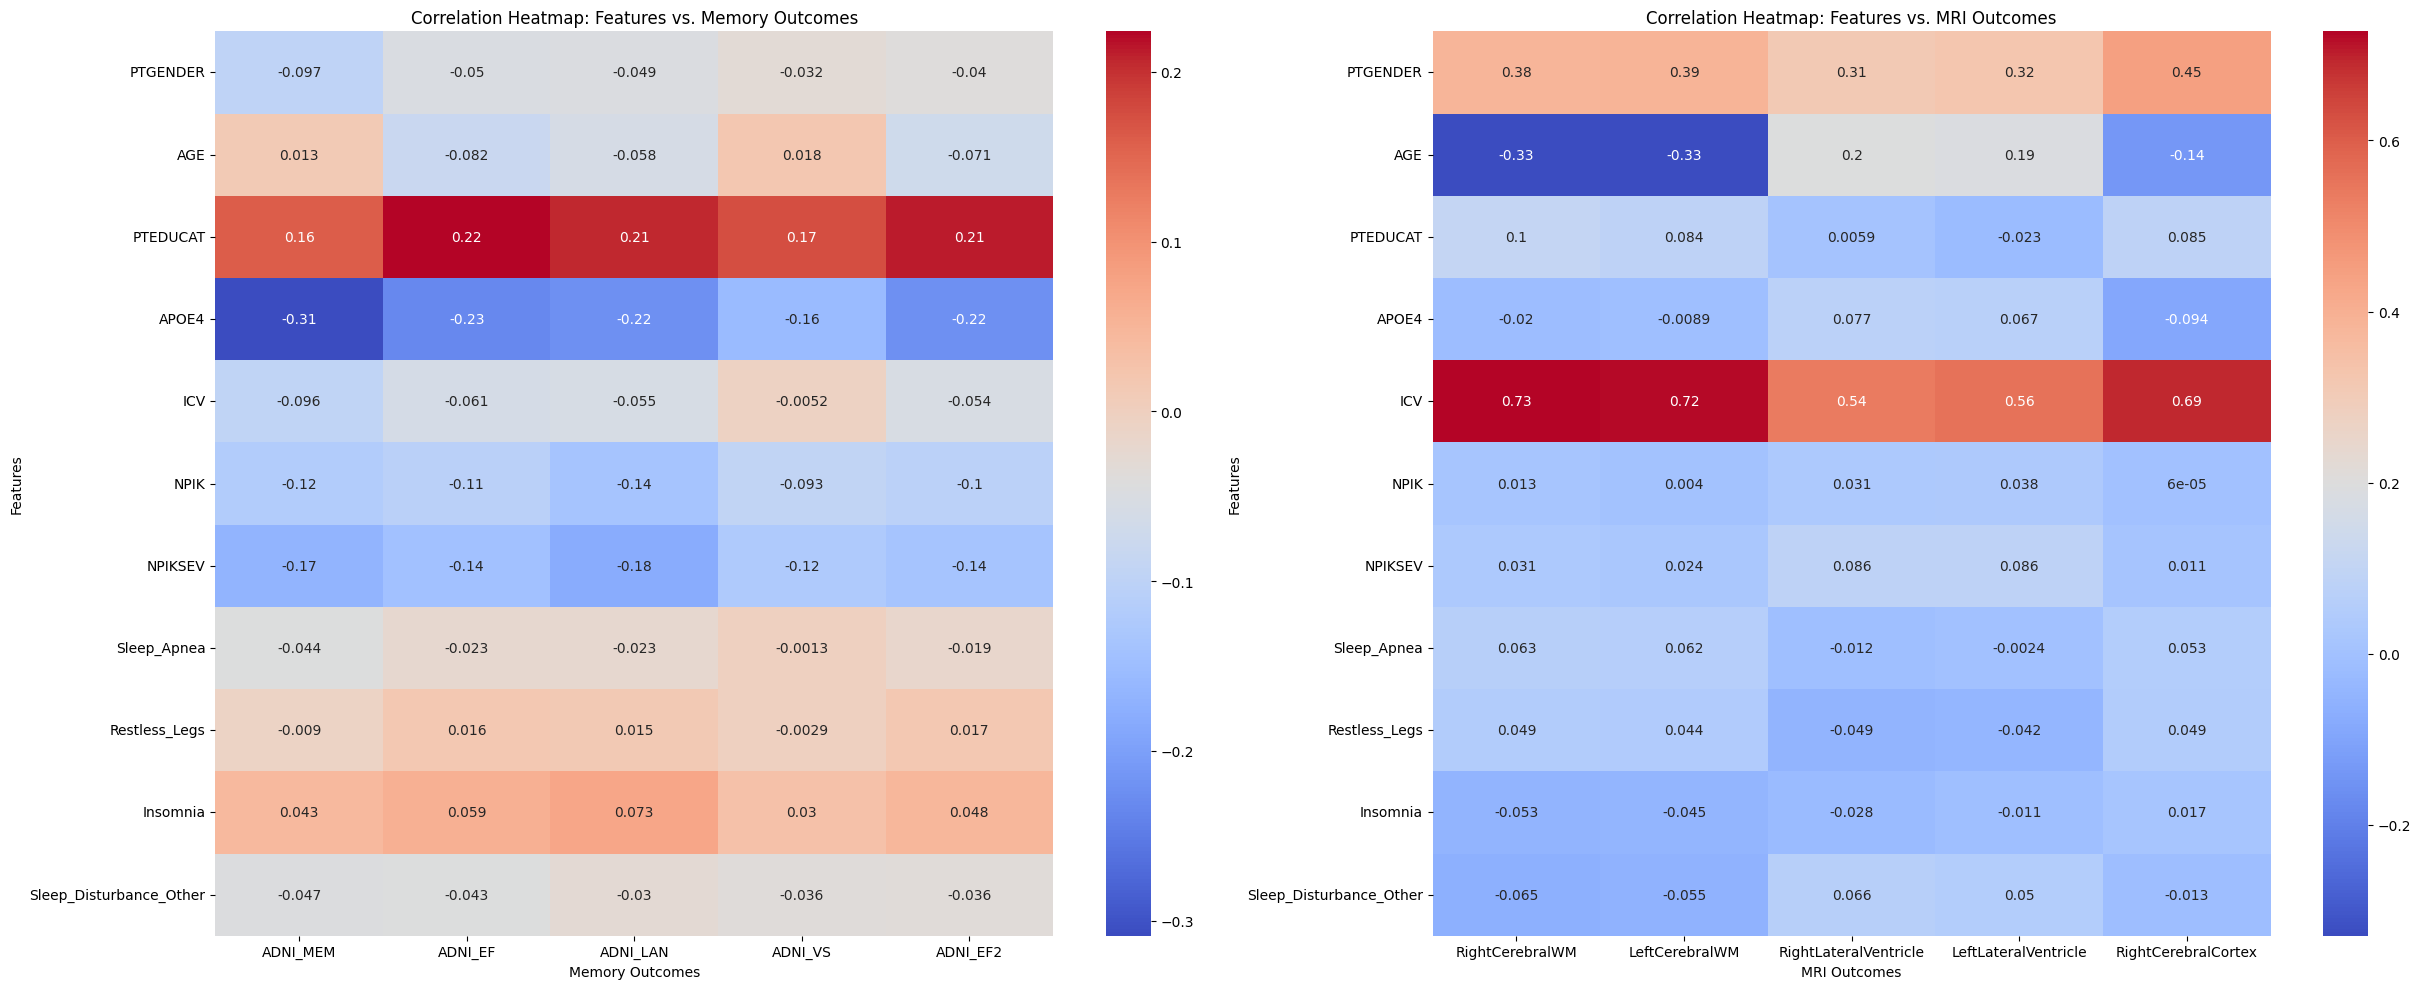

In [177]:
combined_features = predictorsmri + sleep_vars

correlation_memory = merge_norm[memory_outcomes + combined_features].corr()
correlation_memory_features = correlation_memory.loc[combined_features, memory_outcomes]

correlation_mri = merge_norm[top_5_mri_outcomes + combined_features].corr()
correlation_mri_features = correlation_mri.loc[combined_features, top_5_mri_outcomes]
fig, axes = plt.subplots(1, 2, figsize=(25, 10))

sns.heatmap(
    correlation_memory_features, annot=True, cmap='coolwarm', cbar=True, ax=axes[0]
)
axes[0].set_title('Correlation Heatmap: Features vs. Memory Outcomes')
axes[0].set_xlabel('Memory Outcomes')
axes[0].set_ylabel('Features')

sns.heatmap(
    correlation_mri_features, annot=True, cmap='coolwarm', cbar=True, ax=axes[1]
)
axes[1].set_title('Correlation Heatmap: Features vs. MRI Outcomes')
axes[1].set_xlabel('MRI Outcomes')
axes[1].set_ylabel('Features')

plt.tight_layout()
plt.savefig('supplementary_tables/Features_vs_Outcomes_Correlation_Subplots.png', bbox_inches='tight')
plt.show()
